# Example notebook

In [1]:
! rm -rf driveanon

In [2]:
! git clone https://github.com/friedrichknuth/driveanon.git
! pip install -e driveanon

Cloning into 'driveanon'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 146 (delta 2), reused 8 (delta 2), pack-reused 135
Receiving objects: 100% (146/146), 25.88 KiB | 1.52 MiB/s, done.
Resolving deltas: 100% (65/65), done.
Obtaining file:///home/jovyan/pangeo_sprints/contributors/shashank/driveanon
     |████████████████████████████████| 122kB 4.4MB/s eta 0:00:01
  Created wheel for bs4: filename=bs4-0.0.1-cp37-none-any.whl size=1272 sha256=323ab2ab8e1fe1df6a3a9402e295aa324362ca3f9bc25a6b75ab48a221520ae7
  Stored in directory: /home/jovyan/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4
  Running setup.py develop for driveanon


In [1]:
import numpy as np
import os,sys,glob
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import rasterio,gdal
import driveanon as da
from distutils.spawn import find_executable
import dask
import zipfile
from pyproj import Proj, transform
import subprocess
import asp_binder_utils as asp_utils

In [2]:
print(dask.__version__)

2.8.1


In [3]:
#dask.config.config

## Universal settings

In [2]:
verbose = False # will print all the logs printed by ASP
#verbose = 'low' # Will only print the bash commands and whether the process ran sucessfully or not
output_res = 30 # m resolution for output DEM
tsrs = 'EPSG:32610' # projection of output DEM, orthoimages
map_res = 15 # m  resolution for orthorectified input stereo pair

In [3]:
def run_bash_command(cmd):
    #written by Scott Henderson
    # move to asp_binder_utils
    """Call a system command through the subprocess python module."""
    print(cmd)
    try:
        retcode = subprocess.call(cmd, shell=True)
        if retcode < 0:
            print("Child was terminated by signal", -retcode, file=sys.stderr)
        else:
            print("Child returned", retcode, file=sys.stderr)
    except OSError as e:
        print("Execution failed:", e, file=sys.stderr)

## Preprocessing 0: Download the data and stage it on Google Drive

- ASTER L1A data can be ordered from NASA EarthDATA, from https://search.earthdata.nasa.gov/search
- Please select the GeoTiff dilevery before placing the order
- You will get an email when the order is ready, download the zip file and place it in google drive
- Make the file open to all in the google drive setting, we will then use `driveanon` to fetch it on the server
- We have selected a stereo pair over Mt. Rainier stratovolcano in Washington state

In [4]:
#ASTER Sample has been staged at Google Drive, which can be fetched from here:
#https://drive.google.com/open?id=1p39xEPOWzOPoRqhiLL8MUxorof79HD7l
blob_id = '1p39xEPOWzOPoRqhiLL8MUxorof79HD7l'
#url = 'https://docs.google.com/uc?export=download&id={}'.format(aster_location_url) 
fn = 'aster.zip'
if os.path.exists(fn):
    print(f"file {fn} already downloaded")
else:
    da.save(blob_id,fn)
    print(f"file {fn} saved")

file aster.zip saved


In [5]:
aster_top_dir = 'aster_example'
with zipfile.ZipFile(fn, 'r') as zipObj:
   # Extract all the contents of zip file in different directory
   zipObj.extractall(aster_top_dir)

## Preprocessing 1: Create left and right image and assosciated camera models (RPC and rigorous)

- `aster2asp` command takes in the unzipped ASTER image directory and produces 4 files
- Left and right image pairs (Band 3N and Band 3B)
- Two .xml files containing camera information for the left and right image
- The .xml files have both rigrous and RPC camera information

In [6]:
aster2asp = find_executable('aster2asp')
outfolder = 'aster_example_asp/out'
aster2asp_call = f'{aster2asp} {aster_top_dir} -o {outfolder}'

In [7]:
if verbose:
    ! $aster2asp_call
else:
    run_bash_command(aster2asp_call)

/srv/conda/envs/notebook/StereoPipeline/bin/aster2asp aster_example -o aster_example_asp/out


Child returned 0


## Stereo Reconstruction and DEM Generation
- ASP can process an ASTER stereo pair using different modes, with customizable flags in each mode
- We give options for the 3 main modes, users can tweak the flags to see how it goes for them

### Process with RPC camera
- First mode uses `RPC` camera for stereo triangulation and processing
- RPC is a set of polynomial function which is used to approximate actual camera sensor information
- This is the fastest mode to run, as the calculations required during stereo triangulation is minimal
- But as with any approximation, it is less accurate than the actual rigrous camera model

In [8]:
stereo = find_executable('stereo')
session = 'rpc'
spm = 1 
l_img = glob.glob(outfolder+'*3N.tif')[0]
r_img = glob.glob(outfolder+'*3B.tif')[0]
l_img_xml = glob.glob(outfolder+'*3N.xml')[0]
r_img_xml = glob.glob(outfolder+'*3B.xml')[0]
stereo_dir  = 'stereo_rpc/run'
stereo_call = f'{stereo} -t {session} --subpixel-mode {spm} {l_img} {r_img} {l_img_xml} {r_img_xml} {stereo_dir}'
if verbose:
    ! stereo_call
else:
    run_bash_command(stereo_call)

/srv/conda/envs/notebook/StereoPipeline/bin/stereo -t rpc --subpixel-mode 1 aster_example_asp/out-Band3N.tif aster_example_asp/out-Band3B.tif aster_example_asp/out-Band3N.xml aster_example_asp/out-Band3B.xml stereo_rpc/run


Child returned 0


In [9]:
point2dem = find_executable('point2dem')
tr = output_res
tsrs = tsrs
p2dem_args = '--errorimage'
pointcloud = glob.glob(stereo_dir+'*-PC.tif')[0]
print ("Gridding pointcloud {} at {} m/px".format(pointcloud,tr))
point2dem_call  = f'{point2dem} --tr {tr} --t_srs {tsrs} {p2dem_args} {pointcloud}'
if verbose:
    ! $point2dem_call
else:
    run_bash_command(point2dem_call)
dem = glob.glob(stereo_dir+'*-DEM.tif')[0]
print("DEM saved at {}".format(dem))

Gridding pointcloud stereo_rpc/run-PC.tif at 30 m/px
/srv/conda/envs/notebook/StereoPipeline/bin/point2dem --tr 30 --t_srs EPSG:32610 --errorimage stereo_rpc/run-PC.tif
DEM saved at stereo_rpc/run-DEM.tif


Child returned 0


Found files stereo_rpc/run-L.tif
 stereo_rpc/run-R.tif
 stereo_rpc/run-F.tif
 stereo_rpc/run-IntersectionErr.tif
 stereo_rpc/run-DEM.tif



/srv/conda/envs/notebook/lib/python3.7/site-packages/rasterio/__init__.py:219: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


[0.29919155 0.75494647]
[  39.30957031 2274.35146484]
<class 'numpy.ma.core.MaskedArray'>


/srv/conda/envs/notebook/lib/python3.7/site-packages/matplotlib/image.py:443: RuntimeWarning: overflow encountered in multiply
  A_resampled *= ((a_max - a_min) / 0.8)


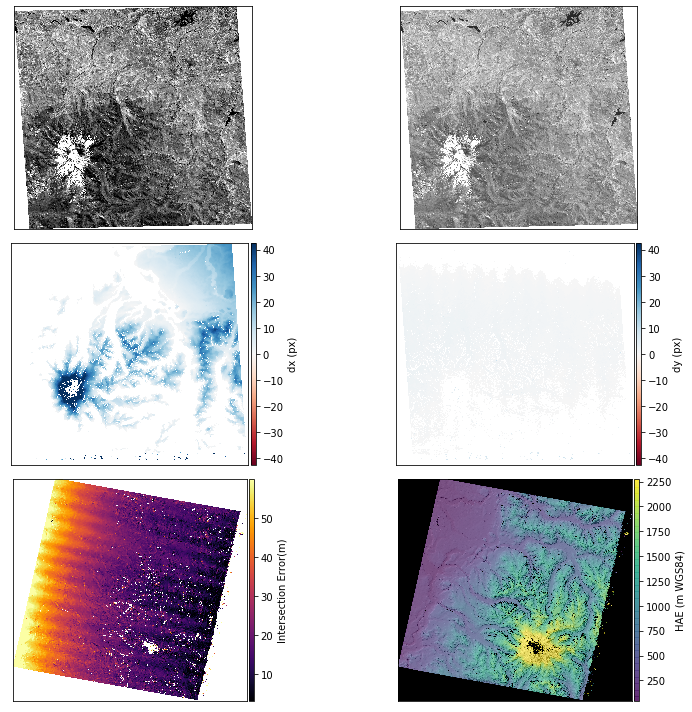

In [10]:
fig,ax = plt.subplots(3,2,figsize=(12,10))
asp_utils.plot_stereo_results(stereo_dir,ax)

- The first two images are the left and right stereo pairs
- Notice they might seem to be flipped ! This is because they are aligned along the affine epipolar line by `stereo_pprc`, so the ASP's matching algorithms search in the effective x direction only 
- The second row are the filtered sub-pixel disparity maps (pixel offsets in the right image corresponding to left image, you can see that most of the disparity is in the x disparity only (left), the y disparity is almost 0 (due to the initial alignment).
- The third row contains the ray intersection error map and DEM overlaid on the corresponding hillshade.
- In general, intersection error used to evaluate camera pointing accuracy, lower error: self-consistent camera.

### Process with ASTER Rigrous Camera Model

- The second mode uses ASTER Rigrous camera model
- This computation is slower but more accurate, the actual spacecraft attitude and ephermis data is used during triangulation step.

In [7]:
stereo = find_executable('stereo')
session = 'aster'
spm = 1 
l_img = glob.glob(outfolder+'*3N.tif')[0]
r_img = glob.glob(outfolder+'*3B.tif')[0]
l_img_xml = glob.glob(outfolder+'*3N.xml')[0]
r_img_xml = glob.glob(outfolder+'*3B.xml')[0]
stereo_dir  = 'stereo_aster_session/run'
stereo_call  = f'{stereo} -t {session} --subpixel-mode {spm} {l_img} {r_img} {l_img_xml} {r_img_xml} {stereo_dir}'
if verbose:
    ! stereo_call
else:
    run_bash_command(stereo_call)

/srv/conda/envs/notebook/StereoPipeline/bin/stereo -t aster --subpixel-mode 1 aster_example_asp/out-Band3N.tif aster_example_asp/out-Band3B.tif aster_example_asp/out-Band3N.xml aster_example_asp/out-Band3B.xml stereo_aster_session/run


Child returned 0


In [10]:
point2dem = find_executable('point2dem')
tr = output_res
tsrs = tsrs
p2dem_args = '--errorimage'
pointcloud = glob.glob(stereo_dir+'*-PC.tif')[0]
print ("Gridding pointcloud {} at {} m/px".format(pointcloud,tr))
point2dem_call = f'{point2dem} --tr {tr} --t_srs {tsrs} {p2dem_args} {pointcloud}'
if verbose:
    ! $point2dem_call
else:
    run_bash_command(point2dem_call)
dem = glob.glob(stereo_dir+'*-DEM.tif')[0]
print("DEM saved at {}".format(dem))

Gridding pointcloud stereo_aster_session/run-PC.tif at 30 m/px
/srv/conda/envs/notebook/StereoPipeline/bin/point2dem --tr 30 --t_srs EPSG:32610 --errorimage stereo_aster_session/run-PC.tif
DEM saved at stereo_aster_session/run-DEM.tif


Child returned 0


Found files stereo_aster_session/run-L.tif
 stereo_aster_session/run-R.tif
 stereo_aster_session/run-F.tif
 stereo_aster_session/run-IntersectionErr.tif
 stereo_aster_session/run-DEM.tif



/srv/conda/envs/notebook/lib/python3.7/site-packages/rasterio/__init__.py:219: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


[0.29926437 0.75492691]
[  82.92871094 2248.69824219]
<class 'numpy.ma.core.MaskedArray'>


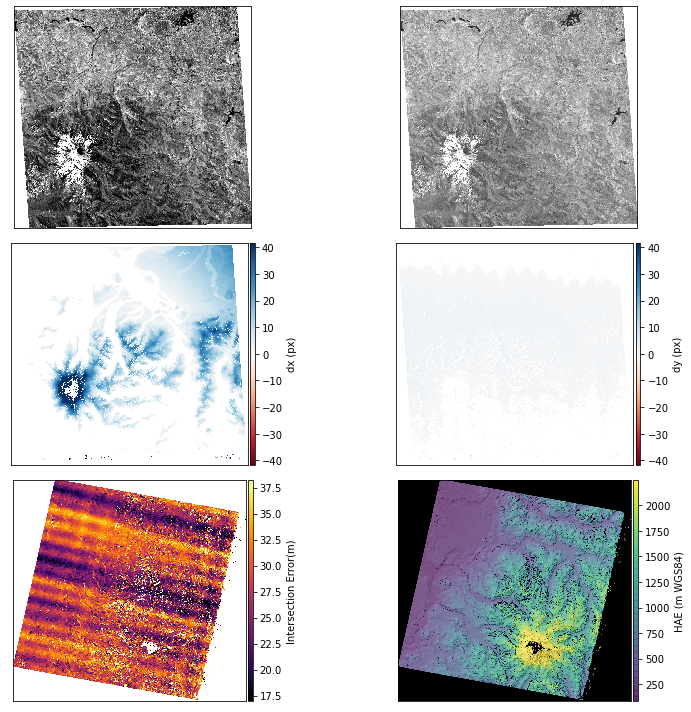

In [11]:
fig,ax = plt.subplots(3,2,figsize=(12,10))
asp_utils.plot_stereo_results(stereo_dir,ax)

### Use Orthorectified stereo inputs

- ASP can use orthorectified stereo input images
- Orthorectification helps in removing terrain disparity, helpful over steep areas (like the failed correlation over the Mt. Rainier volcano top. (see DEM above))
- When the point cloud triangulation occurs, the orthorectification is undone using the camera information and DEM.
- Here we will programmetically fetch SRTM DEM (GL1 Ellipsoidal) using the `opentopography api` 
- Input left and right image will be orthorectified using the downloaded SRTM DEM.
- The `stereo` and `point2dem` calls will then be evoked as usual.

### Subsetting Function

In [16]:
#import elevation
stereo_dir  = 'stereo_rpc/run'
srtm_aster_map = os.path.join(os.getcwd(),'srtm_orig.tif')
dem_file = glob.glob(stereo_dir+'*-DEM.tif')[0]
# get aoi extent in geographic coordinates
aoi_extent = asp_utils.subsetBBox(dem_file,'EPSG:4326')
#in_crs = rasterio.open(dem_file).crs

In [63]:
reference_srtm = asp_utils.get_dem('SRTMGL1_E',aoi_extent,proj=tsrs)
reference_srtm

'SRTMGL1_E_proj.tif'

- We will now orthorectify the left and right stereo images using ASP's `mapproject` call and the adjusted SRTM DEM
- We will use the `rpc` camera for orthorectification (it is faster), while use the `rigrous ASTER` camera during triangulation, as it is more accurate.

In [64]:
mapproject = find_executable('mapproject')
l_map = os.path.splitext(l_img)[0]+'_map_utm.tif'
r_map = os.path.splitext(r_img)[0]+'_map_utm.tif'
mapproject_left_img_call = f'{mapproject} -t rpc --tr {map_res} --t_srs {tsrs} {reference_srtm} {l_img} {l_img_xml} {l_map}'
mapproject_right_img_call = f'{mapproject} -t rpc --tr {map_res} --t_srs {tsrs} {reference_srtm} {r_img} {r_img_xml} {r_map}'
if verbose:
    ! $mapproject_left_img_call
    ! $mapproject_right_img_call
else:
    run_bash_command(mapproject_left_img_call)
    run_bash_command(mapproject_right_img_call)

/srv/conda/envs/notebook/StereoPipeline/bin/mapproject -t rpc --tr 15 --t_srs EPSG:32610 SRTMGL1_E_proj.tif aster_example_asp/out-Band3N.tif aster_example_asp/out-Band3N.xml aster_example_asp/out-Band3N_map_utm.tif


Child returned 0


/srv/conda/envs/notebook/StereoPipeline/bin/mapproject -t rpc --tr 15 --t_srs EPSG:32610 SRTMGL1_E_proj.tif aster_example_asp/out-Band3B.tif aster_example_asp/out-Band3B.xml aster_example_asp/out-Band3B_map_utm.tif


Child returned 0


- Now we can use the mapprojected image to rerun Stereo command
- This makes the process run faster during correlation stage, as the correlator's work in finding matches is reduced due to the smaller search range.
- Mapprojection improves correlation results in featureless or high sloped areas, like the snow-covered mountain tops

- The stereo call remains the same, we just need to update left and right image with their orthorectified ones, and provide a DEM after specifying the output directory, so that it can be used during triangulation to undo mapprojection

In [65]:
stereo = find_executable('stereo')
session = 'astermaprpc'
spm = 1 
stereo_dir  = 'stereo_aster_session_mapprojected/run'
stereo_call = f'{stereo} -t {session} --skip-rough-homography --subpixel-mode {spm} {l_map} {r_map} {l_img_xml} {r_img_xml} {stereo_dir} {reference_srtm}'
if  verbose:
    ! $stereo_call
else:
    run_bash_command(stereo_call)

/srv/conda/envs/notebook/StereoPipeline/bin/stereo -t astermaprpc --skip-rough-homography --subpixel-mode 1 aster_example_asp/out-Band3N_map_utm.tif aster_example_asp/out-Band3B_map_utm.tif aster_example_asp/out-Band3N.xml aster_example_asp/out-Band3B.xml stereo_aster_session_mapprojected/run SRTMGL1_E_proj.tif


Child returned 0


In [66]:
point2dem = find_executable('point2dem')
tr = output_res
tsrs = tsrs
p2dem_args = '--errorimage'
pointcloud = glob.glob(stereo_dir+'*-PC.tif')[0]
print ("Gridding pointcloud {} at {} m/px".format(pointcloud,tr))
point2dem_call = f'{point2dem} --tr {tr} --t_srs {tsrs} {p2dem_args} {pointcloud}'
if verbose:
    ! $point2dem_call
else:
    run_bash_command(point2dem_call)
dem = glob.glob(stereo_dir+'*-DEM.tif')[0]
print("DEM saved at {}".format(dem))

Gridding pointcloud stereo_aster_session_mapprojected/run-PC.tif at 30 m/px
/srv/conda/envs/notebook/StereoPipeline/bin/point2dem --tr 30 --t_srs EPSG:32610 --errorimage stereo_aster_session_mapprojected/run-PC.tif
DEM saved at stereo_aster_session_mapprojected/run-DEM.tif


Child returned 0


Found files stereo_aster_session_mapprojected/run-L.tif
 stereo_aster_session_mapprojected/run-R.tif
 stereo_aster_session_mapprojected/run-F.tif
 stereo_aster_session_mapprojected/run-IntersectionErr.tif
 stereo_aster_session_mapprojected/run-DEM.tif

[0.27470184 0.74587843]
[  85.70525391 2332.94443359]
<class 'numpy.ma.core.MaskedArray'>


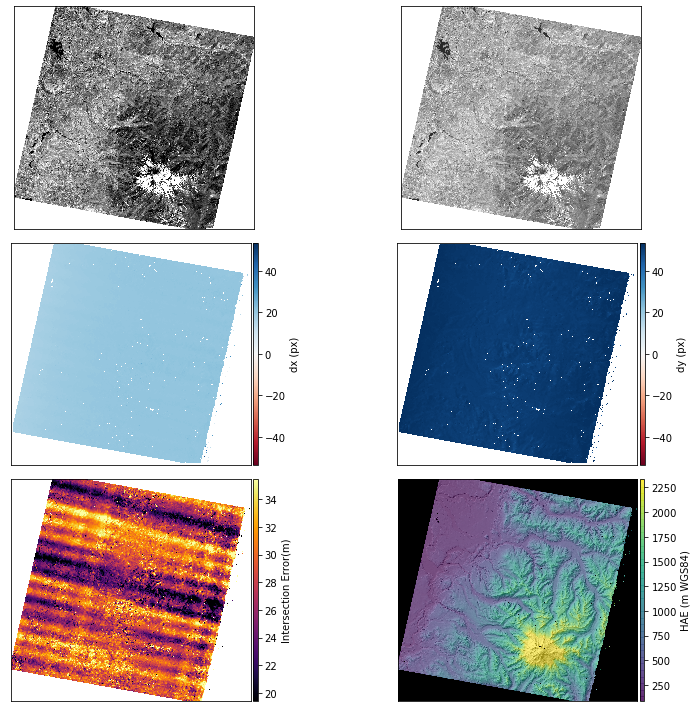

In [28]:
fig,ax = plt.subplots(3,2,figsize=(12,10))
asp_utils.plot_stereo_results(stereo_dir,ax)

- Note the left and right images are oriented correctly (they are already orthorectified)
- The output DEM is complete over the volcano top